In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
base_path = '../../'
sys.path.append(base_path)

In [3]:
from cooldata.dgl_flow_field_dataset import DGLSurfaceFlowFieldDataset
from cooldata.pyvista_flow_field_dataset import PyvistaFlowFieldDataset
ds_pv = PyvistaFlowFieldDataset.load_from_huggingface("datasets/pyvista",num_samples=100)
ds_dgl = DGLSurfaceFlowFieldDataset(os.path.join(base_path,'datasets/dgl_surface'),ds_pv)
ds_dgl = DGLSurfaceFlowFieldDataset(os.path.join(base_path,'datasets/dgl_surface'))
ds_dgl[0]

Loaded 100 samples from '/nfs/homedirs/peo/flow_field_dataset/examples/meshgraphnet/datasets/pyvista'.
Loaded 100 samples from 'datasets/pyvista'.


Graph(num_nodes=34829, num_edges=278612,
      ndata_schemes={'BodyID': Scheme(shape=(), dtype=torch.int32), 'SurfaceType': Scheme(shape=(), dtype=torch.int32), 'CellArea': Scheme(shape=(), dtype=torch.float32), 'Normal': Scheme(shape=(3,), dtype=torch.float32), 'ShearStress': Scheme(shape=(3,), dtype=torch.float32), 'Position': Scheme(shape=(3,), dtype=torch.float32), 'Temperature': Scheme(shape=(), dtype=torch.float32), 'Pressure': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'dx': Scheme(shape=(3,), dtype=torch.float32)})

In [4]:
ds_dgl[0].ndata["Pressure"].mean()

tensor(-0.1158)

In [5]:
ds_pv[0]

2025-06-08 13:56:43.547 (  12.288s) [    79AA50EFE740]      vtkCGNSReader.cxx:4267  WARN| vtkCGNSReader (0x57ab78669770): Skipping BC_t node: BC_t type 'BCInflow' not supported yet.
2025-06-08 13:56:43.547 (  12.288s) [    79AA50EFE740]      vtkCGNSReader.cxx:4267  WARN| vtkCGNSReader (0x57ab78669770): Skipping BC_t node: BC_t type 'BCSymmetryPlane' not supported yet.
2025-06-08 13:56:43.547 (  12.288s) [    79AA50EFE740]      vtkCGNSReader.cxx:4267  WARN| vtkCGNSReader (0x57ab78669770): Skipping BC_t node: BC_t type 'BCTunnelOutflow' not supported yet.


In [6]:
ds_dgl[0]

Graph(num_nodes=34829, num_edges=278612,
      ndata_schemes={'BodyID': Scheme(shape=(), dtype=torch.int32), 'SurfaceType': Scheme(shape=(), dtype=torch.int32), 'CellArea': Scheme(shape=(), dtype=torch.float32), 'Normal': Scheme(shape=(3,), dtype=torch.float32), 'ShearStress': Scheme(shape=(3,), dtype=torch.float32), 'Position': Scheme(shape=(3,), dtype=torch.float32), 'Temperature': Scheme(shape=(), dtype=torch.float32), 'Pressure': Scheme(shape=(), dtype=torch.float32)}
      edata_schemes={'dx': Scheme(shape=(3,), dtype=torch.float32)})

In [7]:
from dgl.dataloading import GraphDataLoader
import torch
full_dataloader = GraphDataLoader(ds_dgl, batch_size=1, shuffle=False)

In [8]:
import dgl


def get_node_edge_X(graph: dgl.DGLGraph):
    node_X = torch.cat([graph.ndata["Position"], graph.ndata["Normal"], torch.nn.functional.one_hot(graph.ndata["SurfaceType"].long(), num_classes=5)],dim=1)
    edge_X = torch.cat([graph.edata["dx"]],dim=1)
    return node_X, edge_X

def get_node_Y(graph: dgl.DGLGraph):
    return torch.cat([graph.ndata["Pressure"].unsqueeze(1),graph.ndata["Temperature"].unsqueeze(1),graph.ndata['ShearStress']],dim=1)

def set_graph_features(graph: dgl.DGLGraph, node_X, edge_X, node_Y):
    graph.ndata["Position"] = node_X[:,:3]
    graph.ndata["Normal"] = node_X[:,3:6]
    graph.ndata["SurfaceType"] = node_X[:,6:11].argmax(dim=1)
    graph.edata["dx"] = edge_X
    graph.ndata["Pressure"] = node_Y[:,0]
    graph.ndata["Temperature"] = node_Y[:,1]
    graph.ndata["ShearStress"] = node_Y[:,2:]
g=ds_dgl[0]
g_cp=g.clone()
ndx, edx = get_node_edge_X(g)
ndy = get_node_Y(g)
set_graph_features(g_cp, ndx, edx, ndy)
assert torch.allclose(g_cp.ndata["Position"], g.ndata["Position"])
assert torch.allclose(g_cp.ndata["Normal"], g.ndata["Normal"])
assert torch.allclose(g_cp.edata["dx"], g.edata["dx"])
assert torch.allclose(g_cp.ndata["Pressure"], g.ndata["Pressure"])
assert torch.allclose(g_cp.ndata["Temperature"], g.ndata["Temperature"])
assert torch.allclose(g_cp.ndata["ShearStress"], g.ndata["ShearStress"])
num_node_features = ndx.shape[1]
num_edge_features = edx.shape[1]
num_node_labels = ndy.shape[1]
print("Node X: ",ndx, ndx.shape)
print("Edge X: ",edx, edx.shape)
print("Node Y: ",ndy, ndy.shape)

Node X:  tensor([[-1.6381,  1.4734,  0.9944,  ...,  0.0000,  1.0000,  0.0000],
        [-1.6247,  1.4734,  0.9944,  ...,  0.0000,  1.0000,  0.0000],
        [-1.6381,  1.4734,  0.9644,  ...,  0.0000,  1.0000,  0.0000],
        ...,
        [ 1.6966, -1.4371, -1.2292,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.6966, -1.3783, -1.2591,  ...,  1.0000,  0.0000,  0.0000],
        [ 1.6966, -1.4371, -1.2591,  ...,  1.0000,  0.0000,  0.0000]]) torch.Size([34829, 11])
Edge X:  tensor([[ 1.1945e+00,  2.8222e-10,  1.7533e-10],
        [ 2.2358e-10,  2.8222e-10, -3.6570e-01],
        [ 1.1945e+00,  2.8222e-10, -3.6570e-01],
        ...,
        [ 2.2358e-10,  2.8222e-10,  3.6570e-01],
        [ 2.2358e-10,  1.3346e+00,  1.7533e-10],
        [-5.9725e-01, -6.6731e-01,  1.7533e-10]]) torch.Size([278612, 3])
Node Y:  tensor([[ 0.3951, -0.6498, -0.4775,  0.0042, -0.0406],
        [ 0.3617, -0.6492, -0.4775,  0.0042, -0.0406],
        [ 0.3920, -0.6502, -0.4775,  0.0042, -0.0406],
        ...,
     

In [9]:
from modulus.models.meshgraphnet import MeshGraphNet
model = MeshGraphNet(
    input_dim_nodes=num_node_features,
    input_dim_edges=num_edge_features,
    output_dim=num_node_labels,
    aggregation='sum',
    hidden_dim_edge_encoder=64,
    hidden_dim_node_encoder=64,
    hidden_dim_processor=64,
    hidden_dim_node_decoder=64
)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
#from torch.amp import GradScaler
optimizer = Adam(model.parameters(), lr=1e-3)
scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.99985 ** epoch)
#scaler = GradScaler(device=device)
scaler = None

def compute_loss(batch):
    batch = batch.to(device)
    node_X, edge_X = get_node_edge_X(batch)
    node_Y = get_node_Y(batch)
    node_Y_pred = model(node_X,edge_X,batch)
    batch_pred_graph = batch.clone()
    set_graph_features(batch_pred_graph, node_X, edge_X, node_Y_pred)
    agg_force_pred = ds_dgl.compute_aggregate_force(batch_pred_graph)
    agg_force = ds_dgl.compute_aggregate_force(batch)
    #print('Agg force pred: ',format_vector(agg_force_pred.tolist()),' Agg force: ',format_vector(agg_force.tolist()))
    return torch.nn.functional.mse_loss(node_Y_pred,node_Y) + 0.8* torch.nn.functional.mse_loss(agg_force_pred,agg_force)

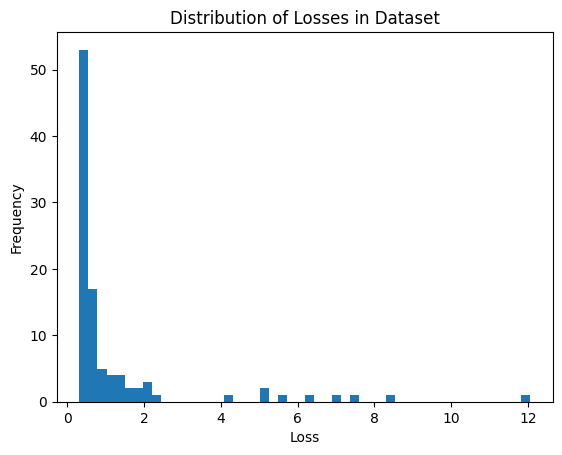

10 samples with highest losses: [7, 33, 34, 64, 71, 80, 87, 88, 91, 96]


In [10]:
from matplotlib import pyplot as plt
os.makedirs('figures', exist_ok=True)

def plot_losses_by_sample():
    losses_by_sample = []
    for i, batch in enumerate(full_dataloader):
        loss = compute_loss(batch)
        losses_by_sample.append(loss.item())
    plt.hist(losses_by_sample, bins=50)
    plt.xlabel('Loss')
    plt.ylabel('Frequency')
    plt.title('Distribution of Losses in Dataset')
    plt.savefig('figures/loss_frequency_dgl.pdf', bbox_inches='tight')
    plt.show()
    top_loss_indices = sorted(range(len(losses_by_sample)), key=lambda i: losses_by_sample[i], reverse=True)[:10]
    print("10 samples with highest losses:", sorted(top_loss_indices))
    return losses_by_sample
losses_by_sample = plot_losses_by_sample()

In [15]:
import pyvista as pv
pv.set_jupyter_backend("trame")
ds_dgl.plot_surface(ds_dgl[33],"Pressure")

Widget(value='<iframe src="http://localhost:44007/index.html?ui=P_0x79a817f6e610_4&reconnect=auto" class="pyvi…

In [22]:
median_loss = torch.median(torch.tensor(losses_by_sample))
print("Median loss:", median_loss.item())
indices_without_spikes = [i for i, loss in enumerate(losses_by_sample) if loss < median_loss * 5]
len(indices_without_spikes)

Median loss: 0.46474090218544006


91

In [24]:
ds_dgl_usable = ds_dgl.select_subset(indices_without_spikes)
num_train_samples = int(len(ds_dgl_usable) * 0.5)
num_val_samples = len(ds_dgl_usable) - num_train_samples
ds_dgl_usable.shuffle()
train_ds = ds_dgl_usable.slice(0, num_train_samples)
val_ds = ds_dgl_usable.slice(num_train_samples, num_train_samples + num_val_samples)

dataloader = GraphDataLoader(train_ds, batch_size=1, shuffle=True)
val_dataloader = GraphDataLoader(val_ds, batch_size=1, shuffle=False)
len(train_ds), len(val_ds)

(45, 46)

In [26]:

from modulus.launch.utils import save_checkpoint, load_checkpoint
checkpoint_path = 'checkpoints'
os.makedirs(checkpoint_path,exist_ok=True)
epoch_init = 0 #load_checkpoint(checkpoint_path,model,optimizer,scheduler,scaler,device=device)
num_epochs = 400
model.to(device)


def compute_average_loss(dataloader):
    total_loss = 0
    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            loss = compute_loss(batch)
            total_loss += loss.item()
    return total_loss / len(dataloader)
for epoch in range(epoch_init,num_epochs):
    train_set_loss = compute_average_loss(dataloader)
    val_set_loss = compute_average_loss(val_dataloader)
    print(f'Epoch {epoch} train loss: {train_set_loss} val loss: {val_set_loss}')
    model.train()
    for batch in dataloader:
        loss = compute_loss(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
   
    scheduler.step()
    if epoch % 10 == 0:
        save_checkpoint(checkpoint_path,model,optimizer,scheduler,scaler,epoch)
save_checkpoint(checkpoint_path,model,optimizer,scheduler,scaler,num_epochs)

Epoch 0 train loss: 0.628010223640336 val loss: 0.5647622677295104


`DistributedManager` not initialized already. Initializing now, but this might lead to unexpected errors
/nfs/homedirs/peo/flow_field_dataset/.venv/lib/python3.11/site-packages/modulus/distributed/manager.py:346: UserWarning: Could not initialize using ENV, SLURM or OPENMPI methods. Assuming this is a single process job
  warn(


Epoch 1 train loss: 0.48589990155564416 val loss: 0.42121172234739945
Epoch 2 train loss: 0.46284702403677835 val loss: 0.38662125324101554
Epoch 3 train loss: 0.4627443549533685 val loss: 0.39703813276213146
Epoch 4 train loss: 0.43621985216935477 val loss: 0.36459360101624677
Epoch 5 train loss: 0.42960855257180003 val loss: 0.35806068178752193
Epoch 6 train loss: 0.4285951433910264 val loss: 0.3556598854129729
Epoch 7 train loss: 0.41839911349945597 val loss: 0.3494250910437625
Epoch 8 train loss: 0.41753836191362803 val loss: 0.35483708702351735
Epoch 9 train loss: 0.41463371904359925 val loss: 0.35882546396359155
Epoch 10 train loss: 0.4081302661862638 val loss: 0.3465907955137284
Epoch 11 train loss: 0.40675975059469544 val loss: 0.3442626308001902
Epoch 12 train loss: 0.41877316708366075 val loss: 0.3509779007214567
Epoch 13 train loss: 0.3876295974685086 val loss: 0.34044535555269406
Epoch 14 train loss: 0.4007519239352809 val loss: 0.33496030565837154
Epoch 15 train loss: 0.41

In [13]:
len(val_dataloader), len(dataloader), len(ds_dgl)

(50, 50, 100)

In [ ]:
model.to(device)
g=ds_dgl[0].to(device)
g_pred = g.clone().to(device)
ndx, edx = get_node_edge_X(g)
with torch.no_grad():
    y_pred = model(ndx,edx,g)
set_graph_features(g_pred, ndx, edx, y_pred)
ds_dgl.plot_surface(g_pred,"Pressure")

Widget(value='<iframe src="http://localhost:44915/index.html?ui=P_0x7a28660cc8d0_1&reconnect=auto" class="pyvi…

In [ ]:
ds_dgl.plot_surface(g,"Pressure")

Widget(value='<iframe src="http://localhost:44915/index.html?ui=P_0x7a28b3f0f310_2&reconnect=auto" class="pyvi…

In [ ]:
ds_dgl.compute_aggregate_force(g, 1)

tensor([-2.6068e-10, -6.7290e-02,  0.0000e+00], device='cuda:0')

In [ ]:
ds_dgl.compute_aggregate_force(g_pred,1)

tensor([ 1.0038e-04, -3.2547e-02, -5.1706e-05], device='cuda:0')